# Автоматический подбор признаков в обучающей выборке:

In [0]:
!pip install --upgrade featuretools
!pip install graphviz
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import time
import graphviz

import featuretools as ft

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
prefix = 'drive/My Drive/automl/data/'

In [4]:
train = pd.read_csv(prefix + 'categorical_less_train.csv')
print(train.shape)

(51253, 95)


# Сущности:

In [0]:
# Загрузим все данные из отдельных таблиц
olist_sellers = pd.read_csv(prefix + "olist_sellers_dataset.csv")
olist_products = pd.read_csv(prefix + "olist_products_dataset.csv")
olist_orders = pd.read_csv(prefix + "olist_orders_dataset.csv")
olist_order_reviews = pd.read_csv(prefix + 'olist_order_reviews_dataset.csv')
olist_order_payments = pd.read_csv(prefix + 'olist_order_payments_dataset.csv')
olist_order_items = pd.read_csv(prefix + 'olist_order_items_dataset.csv')
olist_customers = pd.read_csv(prefix + 'olist_customers_dataset.csv')

Определимся, как формировать отношения на основе идентификаторов:

*   `order_payments` -- идентификаторов нет. возьмем уникальные на основе `order_id`;
*   `order_reviews` -- колонка `review_id` не представляет уникальные значения, поэтому предобработаем;
*   `order_items` -- колонка `order_id` не представляет уникальные значения, поэтому предобработаем;
*   `customers` -- колонка `customer_id` не представляет уникальные значения, поэтому предобработаем;
*   `orders`, `sellers`, `products` содержат уникальные идентификаторы, предобработка не нужна;

In [20]:
# Выделим подмножество данных на основе уникальности идентификаторов

print("olist_order_reviews.shape:", olist_order_reviews.shape)
olist_order_reviews = olist_order_reviews.iloc[olist_order_reviews.drop_duplicates(['order_id']).index, :]
print("olist_order_reviews.shape:", olist_order_reviews.shape)

print("olist_order_payments.shape:", olist_order_payments.shape)
olist_order_payments = olist_order_payments.iloc[olist_order_payments.drop_duplicates(['order_id']).index, :]
print("olist_order_payments.shape:", olist_order_payments.shape)

print("olist_order_items.shape:", olist_order_items.shape)
olist_order_items = olist_order_items.iloc[olist_order_items.drop_duplicates(['order_id']).index, :]
print("olist_order_items.shape:", olist_order_items.shape)

print("olist_customers.shape:", olist_customers.shape)
olist_customers = olist_customers.iloc[olist_customers.drop_duplicates(['customer_id']).index, :]
print("olist_customers.shape:", olist_customers.shape)

olist_order_reviews.shape: (100000, 7)
olist_order_reviews.shape: (99441, 7)
olist_order_payments.shape: (103886, 5)
olist_order_payments.shape: (99440, 5)
olist_order_items.shape: (112650, 7)
olist_order_items.shape: (98666, 7)
olist_customers.shape: (99441, 5)
olist_customers.shape: (99441, 5)


In [0]:
# Объект, характеризующий набор сущностей
es = ft.EntitySet(id = 'clients')

In [0]:
# Заполним EntitySet
es = es.entity_from_dataframe(entity_id='sellers', dataframe=olist_sellers, index='seller_id')
es = es.entity_from_dataframe(entity_id='products', dataframe=olist_products, index='product_id')

es = es.entity_from_dataframe(entity_id='orders', dataframe=olist_orders, index='order_id')
es = es.entity_from_dataframe(entity_id='order_reviews', dataframe=olist_order_reviews, index='order_id')
es = es.entity_from_dataframe(entity_id='order_payments', dataframe=olist_order_payments, index='order_id')
es = es.entity_from_dataframe(entity_id='order_items', dataframe=olist_order_items, index='order_id')
es = es.entity_from_dataframe(entity_id='customers', dataframe=olist_customers, index='customer_id')

In [0]:
r_customer_order = ft.Relationship(es['customers']['customer_id'], es['orders']['customer_id'])

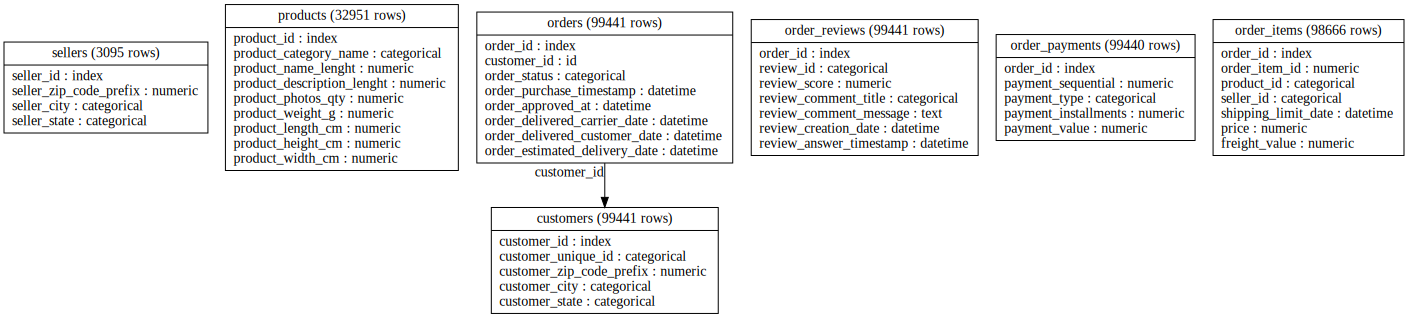

In [0]:
# Теперь эти связи необходимо добавить
es = es.add_relationships([r_customer_order])

# Выведем наш EntitySet
es.plot(to_file=prefix + 'entity.jpg')

In [0]:
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives['type'] == 'aggregation'].head(10)

,name,type,description
0,all,aggregation,Calculates if all values are 'True' in a list.
1,sum,aggregation,"Calculates the total addition, ignoring `NaN`."
2,last,aggregation,Determines the last value in a list.
3,std,aggregation,"Computes the dispersion relative to the mean value, ignoring `NaN`."
4,median,aggregation,Determines the middlemost number in a list of values.
5,avg_time_between,aggregation,Computes the average number of seconds between consecutive events.
6,percent_true,aggregation,Determines the percent of `True` values.
7,num_unique,aggregation,"Determines the number of distinct values, ignoring `NaN` values."
8,min,aggregation,"Calculates the smallest value, ignoring `NaN` values."
9,trend,aggregation,Calculates the trend of a variable over time.


In [0]:
primitives[primitives['type'] == 'transform'].head(30)

,name,type,description
22,add_numeric,transform,Element-wise addition of two lists.
23,cum_count,transform,Calculates the cumulative count.
24,weekday,transform,Determines the day of the week from a datetime.
25,not_equal,transform,Determines if values in one list are not equal to another list.
26,or,transform,Element-wise logical OR of two lists.
27,year,transform,Determines the year value of a datetime.
28,equal,transform,Determines if values in one list are equal to another list.
29,modulo_by_feature,transform,Return the modulo of a scalar by each element in the list.
30,week,transform,Determines the week of the year from a datetime.
31,haversine,transform,Calculates the approximate haversine distance between two LatLong


In [0]:
def choose_primitives(prim_num=5, prim_type='aggregation'):
    size = primitives[primitives['type'] == prim_type].shape[0]
    prim_indices = np.random.randint(0, size, prim_num)
    return np.squeeze(primitives[primitives['type'] == prim_type].values[prim_indices])[:, 0].tolist()

# Примитивная генерация признаков:
На основе DFS (Deep Feature Synthesis) и построенных выше связей мы получим новые признаки для заданной `target_entity`.

Существует два типа примитивных преобразований над признаками:

*   Аггрегация
*   Трансформация

Выделим названия каждой из них и запустим глубинный поиск признаков.


In [0]:
# Выберем некоторые преобразования
agg_primitives = choose_primitives()
trans_primitives = choose_primitives(prim_type='transform')

In [0]:
feature_matrix_spec, feature_names_spec = ft.dfs(entityset=es, target_entity='customers',  
                                                 agg_primitives=agg_primitives,
                                                 trans_primitives=trans_primitives,
                                                 max_depth=2, features_only=False)

In [0]:
feature_matrix_spec.transpose().head(50)

customer_id,06b8999e2fba1a1fbc88172c00ba8bc7,18955e83d337fd6b2def6b18a428ac77,4e7b3e00288586ebd08712fdd0374a03,b2b6027bc5c5109e529d4dc6358b12c3,4f2d8ab171c80ec8364f7c12e35b23ad,879864dab9bc3047522c92c82e1212b8,fd826e7cf63160e536e0908c76c3f441,5e274e7a0c3809e14aba7ad5aae0d407,5adf08e34b2e993982a47070956c5c65,4b7139f34592b3a31687243a302fa75b,9fb35e4ed6f0a14a4977cd9aea4042bb,5aa9e4fdd4dfd20959cad2d772509598,b2d1536598b73a9abd18e0d75d92f0a3,eabebad39a88bb6f5b52376faec28612,1f1c7bf1c9b041b292af6c1c4470b753,206f3129c0e4d7d0b9550426023f0a08,a7c125a0a07b75146167b7f04a7f8e98,c5c61596a3b6bd0cee5766992c48a9a1,9b8ce803689b3562defaad4613ef426f,49d0ea0986edde72da777f15456a0ee0,154c4ded6991bdfa3cd249d11abf4130,690172ab319622688d3b4df42f676898,2938121a40a20953c43caa8c98787fcb,237098a64674ae89babdc426746260fc,cb721d7b4f271fd87011c4c83462c076,f681356046d9fde60e70c73a18d65ea2,167bd30a409e3e4127df5a9408ebd394,6e359a57a91f84095cc64e1b351aef8c,e0eea8f69a457b3f1fa246e44c9ebefd,e3109970a3fe8021d5ff82c577ce5606,261cb4f92498ca05d5bd1a327a261d9c,6f92779347724b67e44e3224f3b4cffd,2d5831cb2dff7cdefba62e950ae3dc7b,b2bed119388167a954382cca36c4777f,469634941c27cd844170935a3cf60b95,df0aa5b8586495e0ddf6b601122e43a1,41c8f4b570869791379a925899a6af8a,54f755c3fd2709231f9964a1430c5218,4c06b42fbf7b97ab10779cda5549cd1c,b6368ca0f56d4632f44d58ca431487b2,...,f9c989b75558c119a7ce8e9f3c2b8f45,cf1ec2659f4b1f34f858a0c25e1d5d1a,4951ae40c746cbd07eecef33fc053e89,21087ff65fd587817c856257e50f2840,d2d1149622911b7c1702c20c92b8ed38,d9110683c7a282144e9fc97660026a28,e98998055b4804137a020830903f93f2,f6c6d3e1e20969a5eed982163f959719,330786b82d1da4f900da3f8124a9f4f0,35de8ab44ecc9a65225a5ef51294d204,da37711b17efd5f2539e8196ab215f04,6fb4f2354f36e554ac80141e9128f528,6928be51d9496f1aab5da8f15a21aba6,eabf770240659f7a6d09b11f12f10f89,184e0c2cfc746789643521df0e9ff904,c156d63bdfce1d456bd43cf1c4dadfca,b7c889215de76857c7967c1011125d2d,30c96385d694acb8aa2dc0df1770120b,a1b5ca506b592bb72d4caadcbfe71385,be631308cb609ff74d0e0fb54815e18c,5eef6cce1f34954c9e7004332388ccc7,821a7275a08f32975caceff2e08ea262,c6ece8a5137f3c9c3a3a12302a19a2ac,e5ed7280cd1a3ac2ba29fd6650d8867c,0a7db3996b88954c7aa763b5dd621d5b,935993f47af1ed7d0715c26b686341c5,592b8900e0e8325027d885e6d30d0283,ffa6d90c36a9c7004692ca50761c69d6,1ed0c832c2dd99570a59260e71768bdf,27b9b32173455ef32167540451749d0b,be842c57a8c5a62e9585dd72f22b6338,f255d679c7c86c24ef4861320d5b7675,14308d2303a3e2bdf4939b86c46d2679,f5a0b560f9e9427792a88bec97710212,7fe2e80252a9ea476f950ae8f85b0f8f,17ddf5dd5d51696bb3d7c6291687be6f,e7b71a9017aa05c9a7fd292d714858e8,5e28dfe12db7fb50a4b2f691faecea5e,56b18e2166679b8a959d72dd06da27f9,274fa6071e5e17fe303b9748641082c8
customer_unique_id,861eff4711a542e4b93843c6dd7febb0,290c77bc529b7ac935b93aa66c333dc3,060e732b5b29e8181a18229c7b0b2b5e,259dac757896d24d7702b9acbbff3f3c,345ecd01c38d18a9036ed96c73b8d066,4c93744516667ad3b8f1fb645a3116a4,addec96d2e059c80c30fe6871d30d177,57b2a98a409812fe9618067b6b8ebe4f,1175e95fb47ddff9de6b2b06188f7e0d,9afe194fb833f79e300e37e580171f22,2a7745e1ed516b289ed9b29c7d0539a5,2a46fb94aef5cbeeb850418118cee090,918dc87cd72cd9f6ed4bd442ed785235,295c05e81917928d76245e842748184d,3151a81801c8386361b62277d7fa5ecf,21f748a16f4e1688a9014eb3ee6fa325,5c2991dbd08bbf3cf410713c4de5a0b5,b6e99561fe6f34a55b0b7da92f8ed775,7f3a72e8f988c6e735ba118d54f47458,3e6fd6b2f0d499456a6a6820a40f2d79,e607ede0e63436308660236f5a52da5e,a96d5cfa0d3181817e2b946f921ea021,482441ea6a06b1f72fe9784756c0ea75,4390ddbb6276a66ff1736a6710205dca,a5844ba4bfc8d0cc61d13027c7e63bcc,5f102dd37243f152aec3607970aad100,9c0096673baf55453a50073f12d1a37f,2e6a42a9b5cbb0da62988694f18ee295,4d221875624017bc47b4d1ce7314a5b7,a8654e2af5da6bb72f52c22b164855e1,424aca6872c5bab80780a8dec03b7516,bf4862777db128507e9efcc789215e9b,e9dd12dca17352644a959d9dea133935,e079b18794454de9d2be5c12b4392294,ef07ba9aa5226f77264ffa5762b2280b,85d234692f7bee8d6fea586e237334b6,fe3634ccefbcdb0537b45fd589e32e8e,40febde16f4718a5def537786473b0be,07d190f123147d9e89d4b922543d7948,dd992305cba295d997f263dbdf4e8c2e,...,c

# Посмотрим на похожую генерацию с двумя другими сущностями:

In [0]:
# Выберем новые преобразования
agg_primitives = choose_primitives(prim_num=10)
trans_primitives = choose_primitives(prim_type='transform')
print("Преобразования вида аггрегации:")
print(agg_primitives)
print("Трансформирующие преобразования:")
print(trans_primitives)

Преобразования вида аггрегации:
['num_unique', 'any', 'sum', 'skew', 'median', 'median', 'avg_time_between', 'num_unique', 'n_most_common', 'min']
Трансформирующие преобразования:
['cum_sum', 'weekday', 'diff', 'divide_numeric', 'greater_than_equal_to']


In [0]:
r_seller_item = ft.Relationship(es['sellers']['seller_id'], es['order_items']['seller_id'])

In [0]:
import time

start = time.time()
feature_matrix_spec, feature_names_spec = ft.dfs(entityset=es, target_entity='sellers',  
                                                 agg_primitives=agg_primitives,
                                                 trans_primitives=trans_primitives,
                                                 max_depth=2, features_only=False)
end = time.time()

print("Автоматическая генерация признаков была выполнена за %.2f" % (end - start))

Автоматическая генерация признаков была выполнена за 0.09


In [0]:
feature_matrix_spec.transpose().head(50)

seller_id,3442f8959a84dea7ee197c632cb2df15,d1b65fc7debc3361ea86b5f14c68d2e2,ce3ad9de960102d0677a81f5d0bb7b2d,c0f3eea2e14555b6faeea3dd58c1b1c3,51a04a8a6bdcb23deccc82b0b80742cf,c240c4061717ac1806ae6ee72be3533b,e49c26c3edfa46d227d5121a6b6e4d37,1b938a7ec6ac5061a66a3766e0e75f90,768a86e36ad6aae3d03ee3c6433d61df,ccc4bbb5f32a6ab2b7066a4130f114e3,8cb7c5ddf41f4d506eba76e9a4702a25,a7a9b880c49781da66651ccf4ba9ac38,8bd0f31cf0a614c658f6763bd02dea69,05a48cc8859962767935ab9087417fbb,7b8e8ec35bad4b0ef7e3963650b0a87b,1444c08e64d55fb3c25f0f09c07ffcf2,166e8f1381e09651983c38b1f6f91c11,e38db885400cd35c71dfd162f2c1dbcf,d2e753bb80b7d4faa77483ed00edc8ca,f9ec7093df3a7b346b7bcf7864069ca3,4e6015589b781adaa5ce7f1892d06bb1,4cf490a58259286ada5ba8525ba9e84a,f7496d659ca9fdaf323c0aae84176632,2ff97219cb8622eaf3cd89b7d9c09824,8bd0e3abda539b9479c4b44a691be1ec,2a1348e9addc1af5aaa619b1a3679d6b,2078fe5066350e7d220c0ad3a3bbc6c1,116ccb1a1604bc88e4d234a8c23f33de,430315b7bb4b6e4b3c978f9dfa9b0558,406822777a0b9eb5c50e442dd4cd3ec5,4dbd95a08b31ede5c82d3f861cb1ce1a,e9e446d01bd10a97a8ffcfc4a3a20cb2,d52cbce9845184537284a23c3bc3da0e,d9a84e1403de8da0c3aa531d6d108ba6,9c690ceacd5c66731bf443ea810195cb,1f9ab4708f3056ede07124aad39a2554,1961c3e1272bfeceb05d0b78b5bbfdaf,d3e7d37c0df9aef383f3f2a15b0dddfb,ec2e006556300a79a5a91e4876ab3a56,b2a6d334e2833acea353624840e25a0e,...,198c7ea11960a9844b544d9bcdca860c,a478c7961d6a992065b24e63b366f90b,30c7f28fd3a5897b2c82d152bb760c17,66e0557ecc2b4dbea057e93f215f68d8,be1e9e378700cecaa4ebf71433d7915c,21e83881401b92b49fb09a16d3852291,55c96925041a14097b6a7825554f4ad5,918f6fbcf3ab724d805867303e593a1b,daeb5653dd96c1b11860f72209795012,228e4c1a0be164f613d41c24345f9d2c,5145090ab595c0d0b8557199f5701fbf,87e24fc7052259b1f7f607d61c10d8be,d66c11a9572221d92fbb8c4897db5f9b,e2c92f9c1c7746d899d18f2e158bbff7,ea67327e24487bdfac5fbfa37ea124df,db6a4d4b5f1f5f98820ce6ce2619e2de,1d1bbb8ac1581824986f582583fff01d,f90f77ef2799a27f80d90c425ca944f7,bbf4a892cac7b82422baa711dffb8997,39f776d2974049026ff531fc42ef2a3e,c70c1b0d8ca86052f45a432a38b73958,9e6967d3cf386d284251784b18ccb485,747e73c01a4593d4cf60dcf970fd2689,63704069d9bd3a75c1cf59babe56004a,4e2627090e6e5b9fabba883a37897683,61b18775be84fb700a6b2d0ba097bf66,95cca791657aabeff15a07eb152d7841,dde698c6d0bd24834c586e5111c2bba7,e94b64dc6979b302a5a5be1662c83bb6,15ead3a5037a918ddb520dfe39a3d2b9,9d489893ff6af05029671b785f54b998,725af026f869236a8dd0ceb98564d156,f00f5b35d0abcacbdd863672f4bb2c1a,7bac63f6603d382cc8d0832eb6c100a8,f1fdf2d13186575751aa25876536d85c,98dddbc4601dd4443ca174359b237166,f8201cab383e484733266d1906e2fdfa,74871d19219c7d518d0090283e03c137,e603cf3fec55f8697c9059638d6c8eb5,9e25199f6ef7e7c347120ff175652c3b
seller_zip_code_prefix,13023,13844,20031,4195,12914,20920,55325,16304,1529,80310,75110,13530,1222,5372,88705,42738,88780,70740,45810,5138,11440,14910,4156,13320,98910,30494,86707,9850,4857,18500,80210,2261,88495,3562,37650,17602,7241,83050,3445,4133,...,37590,89036,24020,4771,14025,38405,2122,13273,31310,86360,82900,5734,20770,15054,14940,2968,89082,86020,82200,74835,13186,9550,55602,13212,31565,14808,85950,25755,6852,36401,13613,35530,1238,5713,5314,87111,88137,4650,96080,12051
seller_city,campinas,mogi guacu,rio de janeiro,sao paulo,braganca paulista,rio de janeiro,brejao,penapolis,sao paulo,curitiba,anapolis,itirapina,sao paulo,sao paulo,tubarao,lauro de freitas,imbituba,brasilia,porto seguro,sao paulo,guaruja,tabatinga,sao paulo,salto,tres de maio,belo horizonte,arapongas,sao bernardo do campo,sao paulo,tatui,curitiba,sao paulo,garopaba,sao paulo,camanducaia,tupa,guarulhos,sao jose dos pinhais,sao paulo,sao paulo,...,jacutinga,blumenau,niteroi,sao paulo,ribeirao preto,uberlandia,sao paulo,valinhos,belo horizonte,bandeirantes,curitiba,sao paulo,rio de janeiro,sao jose do rio preto,ibitinga,sao paulo,indaial,londrina,curitiba,goiania,hortolandia,sao caetano do sul,vitoria de santo antao,jundiai,belo horizonte,araraquara,palotina,petropolis,itapecerica da serra,conselheiro lafaiete,leme,claudio,sao paulo,sao paulo,sao paulo

# Рассмотрим генерацию признаков с тремя сущностями:

In [0]:
# Объект, характеризующий набор сущностей
es = ft.EntitySet(id = 'clients')

# Заполним EntitySet
es = es.entity_from_dataframe(entity_id='sellers', dataframe=olist_sellers, index='seller_id')
es = es.entity_from_dataframe(entity_id='products', dataframe=olist_products, index='product_id')

es = es.entity_from_dataframe(entity_id='orders', dataframe=olist_orders, index='order_id')
es = es.entity_from_dataframe(entity_id='order_reviews', dataframe=olist_order_reviews, index='order_id')
es = es.entity_from_dataframe(entity_id='order_payments', dataframe=olist_order_payments, index='order_id')
es = es.entity_from_dataframe(entity_id='order_items', dataframe=olist_order_items, index='order_id')
es = es.entity_from_dataframe(entity_id='customers', dataframe=olist_customers, index='customer_id')

In [0]:
# Субъекты, организующие заказы
r_product_item = ft.Relationship(es['products']['product_id'], es['order_items']['product_id'])
r_seller_item = ft.Relationship(es['sellers']['seller_id'], es['order_items']['seller_id'])

es = es.add_relationships([r_product_item, r_seller_item])

In [0]:
# Увеличим глубину: положим max_depth = 3

start = time.time()
feature_matrix_spec, feature_names_spec = ft.dfs(entityset=es, target_entity='sellers',  
                                                 agg_primitives=agg_primitives,
                                                 trans_primitives=trans_primitives,
                                                 max_depth=2, features_only=False)
end = time.time()

print("Автоматическая генерация признаков была выполнена за %.2f" % (end - start))

In [0]:
feature_matrix_spec.transpose().head(50)

seller_id,3442f8959a84dea7ee197c632cb2df15,d1b65fc7debc3361ea86b5f14c68d2e2,ce3ad9de960102d0677a81f5d0bb7b2d,c0f3eea2e14555b6faeea3dd58c1b1c3,51a04a8a6bdcb23deccc82b0b80742cf,c240c4061717ac1806ae6ee72be3533b,e49c26c3edfa46d227d5121a6b6e4d37,1b938a7ec6ac5061a66a3766e0e75f90,768a86e36ad6aae3d03ee3c6433d61df,ccc4bbb5f32a6ab2b7066a4130f114e3,8cb7c5ddf41f4d506eba76e9a4702a25,a7a9b880c49781da66651ccf4ba9ac38,8bd0f31cf0a614c658f6763bd02dea69,05a48cc8859962767935ab9087417fbb,7b8e8ec35bad4b0ef7e3963650b0a87b,1444c08e64d55fb3c25f0f09c07ffcf2,166e8f1381e09651983c38b1f6f91c11,e38db885400cd35c71dfd162f2c1dbcf,d2e753bb80b7d4faa77483ed00edc8ca,f9ec7093df3a7b346b7bcf7864069ca3,4e6015589b781adaa5ce7f1892d06bb1,4cf490a58259286ada5ba8525ba9e84a,f7496d659ca9fdaf323c0aae84176632,2ff97219cb8622eaf3cd89b7d9c09824,8bd0e3abda539b9479c4b44a691be1ec,2a1348e9addc1af5aaa619b1a3679d6b,2078fe5066350e7d220c0ad3a3bbc6c1,116ccb1a1604bc88e4d234a8c23f33de,430315b7bb4b6e4b3c978f9dfa9b0558,406822777a0b9eb5c50e442dd4cd3ec5,4dbd95a08b31ede5c82d3f861cb1ce1a,e9e446d01bd10a97a8ffcfc4a3a20cb2,d52cbce9845184537284a23c3bc3da0e,d9a84e1403de8da0c3aa531d6d108ba6,9c690ceacd5c66731bf443ea810195cb,1f9ab4708f3056ede07124aad39a2554,1961c3e1272bfeceb05d0b78b5bbfdaf,d3e7d37c0df9aef383f3f2a15b0dddfb,ec2e006556300a79a5a91e4876ab3a56,b2a6d334e2833acea353624840e25a0e,...,198c7ea11960a9844b544d9bcdca860c,a478c7961d6a992065b24e63b366f90b,30c7f28fd3a5897b2c82d152bb760c17,66e0557ecc2b4dbea057e93f215f68d8,be1e9e378700cecaa4ebf71433d7915c,21e83881401b92b49fb09a16d3852291,55c96925041a14097b6a7825554f4ad5,918f6fbcf3ab724d805867303e593a1b,daeb5653dd96c1b11860f72209795012,228e4c1a0be164f613d41c24345f9d2c,5145090ab595c0d0b8557199f5701fbf,87e24fc7052259b1f7f607d61c10d8be,d66c11a9572221d92fbb8c4897db5f9b,e2c92f9c1c7746d899d18f2e158bbff7,ea67327e24487bdfac5fbfa37ea124df,db6a4d4b5f1f5f98820ce6ce2619e2de,1d1bbb8ac1581824986f582583fff01d,f90f77ef2799a27f80d90c425ca944f7,bbf4a892cac7b82422baa711dffb8997,39f776d2974049026ff531fc42ef2a3e,c70c1b0d8ca86052f45a432a38b73958,9e6967d3cf386d284251784b18ccb485,747e73c01a4593d4cf60dcf970fd2689,63704069d9bd3a75c1cf59babe56004a,4e2627090e6e5b9fabba883a37897683,61b18775be84fb700a6b2d0ba097bf66,95cca791657aabeff15a07eb152d7841,dde698c6d0bd24834c586e5111c2bba7,e94b64dc6979b302a5a5be1662c83bb6,15ead3a5037a918ddb520dfe39a3d2b9,9d489893ff6af05029671b785f54b998,725af026f869236a8dd0ceb98564d156,f00f5b35d0abcacbdd863672f4bb2c1a,7bac63f6603d382cc8d0832eb6c100a8,f1fdf2d13186575751aa25876536d85c,98dddbc4601dd4443ca174359b237166,f8201cab383e484733266d1906e2fdfa,74871d19219c7d518d0090283e03c137,e603cf3fec55f8697c9059638d6c8eb5,9e25199f6ef7e7c347120ff175652c3b
seller_zip_code_prefix,13023,13844,20031,4195,12914,20920,55325,16304,1529,80310,75110,13530,1222,5372,88705,42738,88780,70740,45810,5138,11440,14910,4156,13320,98910,30494,86707,9850,4857,18500,80210,2261,88495,3562,37650,17602,7241,83050,3445,4133,...,37590,89036,24020,4771,14025,38405,2122,13273,31310,86360,82900,5734,20770,15054,14940,2968,89082,86020,82200,74835,13186,9550,55602,13212,31565,14808,85950,25755,6852,36401,13613,35530,1238,5713,5314,87111,88137,4650,96080,12051
seller_city,campinas,mogi guacu,rio de janeiro,sao paulo,braganca paulista,rio de janeiro,brejao,penapolis,sao paulo,curitiba,anapolis,itirapina,sao paulo,sao paulo,tubarao,lauro de freitas,imbituba,brasilia,porto seguro,sao paulo,guaruja,tabatinga,sao paulo,salto,tres de maio,belo horizonte,arapongas,sao bernardo do campo,sao paulo,tatui,curitiba,sao paulo,garopaba,sao paulo,camanducaia,tupa,guarulhos,sao jose dos pinhais,sao paulo,sao paulo,...,jacutinga,blumenau,niteroi,sao paulo,ribeirao preto,uberlandia,sao paulo,valinhos,belo horizonte,bandeirantes,curitiba,sao paulo,rio de janeiro,sao jose do rio preto,ibitinga,sao paulo,indaial,londrina,curitiba,goiania,hortolandia,sao caetano do sul,vitoria de santo antao,jundiai,belo horizonte,araraquara,palotina,petropolis,itapecerica da serra,conselheiro lafaiete,leme,claudio,sao paulo,sao paulo,sao paulo

# Реализуем класс для автоматической генерации:

In [0]:
# Сформируем вспомогательный словарь из названия сущности в ее таблицу данных
entity_to_dataframe = {
    "sellers": olist_sellers,
    "products": olist_products,
    "orders": olist_orders,
    "order_reviews": olist_order_reviews,
    "order_payments": olist_order_payments,
    "order_items": olist_order_items,
    "customers": olist_customers
}

# Сформируем вспомогательный словарь из названия сущности в название ее индекса
entity_to_index = {
    "sellers": "seller_id",
    "products": "product_id",
    "customers": "customer_id",
    "orders": "order_id",
    "order_reviews": "order_id",
    "order_payments": "order_id",
    "order_items": "order_id",
}

In [0]:
# Сформируем вспомогательный словарь отношений между сущностями
entity_to_relations = {
    "orders": [("orders", "order_payments"), ("orders", "order_items"), ("orders", "order_reviews"), ("customers", "orders")],
    "order_payments": [("orders", "order_payments")],
    "order_items": [("orders", "order_items"), ("products", "order_items"), ("sellers", "order_items")],
    "order_reviews": [("orders", "order_reviews")],
    "products": [("products", "order_items")],
    "sellers": [("sellers", "order_items")],
    "customers": [("customers", "orders")]
}

In [0]:
# Необходимые import's и константы
from scipy.stats import pearsonr

# Эти параметры могут считаться гиперпараметрами, но для простоты вычислений мы не будем их подбирать.
NAN_RATIO = 0.2
CORR_BOUND = 1e-4
DIFF_BOUND = 2

TARGET_VALUES = olist_order_items['price'].values

In [0]:
class AutoFE:
    """
    Класс описывает возможности автоматической предобработки с помощью featuretools
    """
    def __init__(self, max_depth=2, agg_primitives=None, trans_primitives=None,
                 uniform_entity_names=list(['sellers', 'order_items']), verbose=True):
        self.es = None
        self.verbose = verbose
        self.max_depth = max_depth
        self.primitives = ft.list_primitives()

        self.agg_primitives = agg_primitives
        self.trans_primitives = trans_primitives

        # счетчики плохо сгенерированных колонок. Будем вести логирующую статистику
        self.pearson_bad_values = 0
        self.nan_bad_values = 0
        self.diff_bad_values = 0

        # Глобальный набор имен сущностей позволяет понять, допустимо ли применение преобразования
        # Для заданного target_entity [см. apply]
        self.uniform_entity_names = uniform_entity_names
    
    # Для случайной генерации может быть полезно посмотреть на выбранные примитивы
    def list_primitives(self):
        return self.agg_primitives, self.trans_primitives

    # Вернем данные для логирования
    def list_counters(self):
        return self.pearson_bad_values, self.nan_bad_values, self.diff_bad_values

    # Нарисуем схему EntitySet
    def draw_entity_set(self):
        if self.es is None:
            self.handle_entity_set(self.uniform_entity_names)
        self.es.plot()
        return

    def choose_primitives(self, prim_num=5, prim_type='aggregation'):
        size = self.primitives[self.primitives['type'] == prim_type].shape[0]
        prim_indices = np.random.randint(0, size, prim_num)
        return np.squeeze(self.primitives[self.primitives['type'] == prim_type].values[prim_indices])[:, 0].tolist()

    # Простая предобработка датафрейма позволит избавиться от совершенно неинформативных признаков
    def simple_cleaning(self, frame):
        global NAN_RATIO, CORR_BOUND, DIFF_BOUND

        start, end = 0, 0
        if self.verbose:
            start = time.time()
            print("simple_cleaning in Started.")

        drop_columns = []
        for col in frame.columns:

            # Сравним число пропусков с допустимым
            nan_ratio = frame[col].isna().sum() / frame.shape[0]
            if nan_ratio >= NAN_RATIO:
                drop_columns.append(col)
                self.nan_bad_values += 1
                if self.verbose:
                    print(f"Column for drop: {col}; Cause: nan_ratio > NAN_RATIO;")
                # Переходим к следующему признаку
                continue

            # Сравним корреляцию Пирсона сгенерированного признака (для нетекстового) с целевой переменной
            if type(frame[col].values[0]) != str:
                vals = frame[col].values[~np.isnan(frame[col].values)]
                mn = min(TARGET_VALUES.shape[0], vals.shape[0])
                first_to_pearson = np.array(TARGET_VALUES[:mn])#, dtype=np.float64)
                second_to_pearson = np.array(vals[:mn])#, dtype=np.float64)
                pearson_value, _ = pearsonr(first_to_pearson, second_to_pearson)
                if pearson_value < CORR_BOUND:
                    drop_columns.append(col)
                    self.pearson_bad_values += 1
                    if self.verbose:
                        print(f"Column for drop: {col}; Cause: pearson_value > CORR_BOUND;")
                    continue
            
            # Сравним множество значений данного признака (для очень маленького Range этот признак нужно отсеять)
            bound = DIFF_BOUND
            if type(frame[col].values[0]) == bool:
                bound == 2
            if frame[col].nunique() < bound:
                drop_columns.append(col)
                self.diff_bad_values += 1
            if self.verbose:
                print(f"Column for drop {col}; Cause: nunique < bound, type = {type(frame[col].values[0])}")

        if self.verbose:
            end = time.time()
            print("simple_cleaning is Done in %.2f seconds." % (end - start))
        return frame.drop(drop_columns, axis=1)

    # В случае неорганизованного EntitySet это необходимо сделать.
    def handle_entity_set(self, entity_names):
        global entity_to_dataframe, entity_to_index, entity_to_relations

        start, end = 0, 0
        if self.verbose:
            print("handle_entity_set is Started.")
            start = time.time()

        # Проверим, что имена данных сущностей лежат в глобальном множестве имён
        for name in entity_names:
            if name not in self.uniform_entity_names:
                raise NameError(f"{name} is not placed in uniform_entity_names.")

        self.es = ft.EntitySet(id='AutoFE')

        # Сначала заполним его сущностями
        for name in entity_names:
            self.es = self.es.entity_from_dataframe(entity_id=name,
                                                    dataframe=entity_to_dataframe[name],
                                                    index=entity_to_index[name])

        # Теперь создадим отношения
        relations = []
        for name in entity_names:
            for relation in entity_to_relations[name]:
                frm, to = relation[0], relation[1]

                # Если это отношение ведет вне данный подграф, опустим его
                if frm not in entity_names or to not in entity_names:
                    continue

                frm_ind, to_ind = entity_to_index[frm], entity_to_index[to]
                relations.append(ft.Relationship(self.es[frm][frm_ind], self.es[to][to_ind]))
        # Добавим их в EntitySet
        self.es = self.es.add_relationships(relations)

        if self.verbose:
            end = time.time()
            print("handle_entity_set is Done in %.2f seconds." % (end - start))

    # Зафиксируем конечную сущность, в которую добавятся сгенерированные признаки
    def apply(self, target_entity):
        if self.verbose:
            start = time.time()
            print("apply is Started.")

        if self.es is None:
            self.handle_entity_set(self.uniform_entity_names)
        assert self.es is not None

        # Проверим, что целевая сущность лежит в искомом множестве
        assert target_entity in self.uniform_entity_names

        # Сгенерируем примитивы, если они не заданы
        if self.agg_primitives is None:
            self.agg_primitives = self.choose_primitives(prim_num=45)
        if self.trans_primitives is None:
            self.trans_primitives = self.choose_primitives(prim_num=15, prim_type='transform')

        if self.verbose:
            print("Сгенерированные аггрегирующие примитивы:")
            print(self.agg_primitives)
            print("Сгенерированные трансформирующие примитивы:")
            print(self.trans_primitives)

        if self.verbose:
            print("depth feature search...")

        # Создадим запрещающий словарь для функции. Данные из этого словаря для генерации выбираться не будут
        ignore_dict = dict()
        for name in self.uniform_entity_names:
            ignore_dict[name] = ['order_id']

        feature_matrix_spec, feature_names_spec = ft.dfs(entityset=self.es, target_entity=target_entity,  
                                                 agg_primitives=self.agg_primitives,
                                                 trans_primitives=self.trans_primitives,
                                                 max_depth=self.max_depth, features_only=False,
                                                 ignore_variables=ignore_dict)
        
        if self.verbose:
            print("feature_matrix_spec.shape:", feature_matrix_spec.shape)
            print("simple_cleaning...")
        # Почистим сгенерированные признаки
        feature_matrix_spec = self.simple_cleaning(feature_matrix_spec)
        if self.verbose:
            print("feature_matrix_spec.shape after simple_cleaning:", feature_matrix_spec.shape)

        if self.verbose:
            end = time.time()
            print("apply is Done in %.2f seconds." % (end - start))
        return feature_matrix_spec, feature_names_spec

# Предобработаем данные с помощью полученного функционала:

In [13]:
auto_fe = AutoFE(max_depth=2)
auto_fe.draw_entity_set()

handle_entity_set is Started.
2020-06-03 16:12:47,164 featuretools.entityset - WARNING    Not adding duplicate relationship: <Relationship: order_items.order_id -> sellers.seller_id>
handle_entity_set is Done in 0.15 seconds.


In [14]:
feature_matrix_spec, feature_names_spec = auto_fe.apply('sellers')

apply is Started.
Сгенерированные аггрегирующие примитивы:
['any', 'avg_time_between', 'min', 'last', 'avg_time_between', 'max', 'time_since_first', 'min', 'all', 'entropy', 'skew', 'all', 'avg_time_between', 'mean', 'std', 'trend', 'first', 'num_unique', 'max', 'sum', 'count', 'n_most_common', 'mode', 'max', 'max', 'sum', 'last', 'median', 'time_since_first', 'percent_true', 'last', 'time_since_first', 'skew', 'num_true', 'std', 'n_most_common', 'min', 'mode', 'max', 'any', 'all', 'time_since_first', 'num_unique', 'all', 'count']
Сгенерированные трансформирующие примитивы:
['latitude', 'cum_count', 'add_numeric_scalar', 'equal', 'add_numeric_scalar', 'day', 'percentile', 'modulo_numeric_scalar', 'is_null', 'second', 'cum_count', 'hour', 'multiply_numeric', 'divide_numeric', 'cum_max']
depth feature search...
2020-06-03 16:12:48,924 featuretools - WARNING    Attempting to add feature <Feature: order_item_id + 0> which is already present. This is likely a bug.
2020-06-03 16:12:48,925 fe

In [15]:
nan_cnt, pearson_cnt, diff_cnt = auto_fe.list_counters()

print("Число колонок с большим количеством пропусков:", nan_cnt)
print("Число колонок с низкой корреляцией:", pearson_cnt)
print("Число колонок с маленьким множеством значений:", diff_cnt)
print("Общее число колонок:", len(feature_names_spec))

Число колонок с большим количеством пропусков: 14
Число колонок с низкой корреляцией: 2166
Число колонок с маленьким множеством значений: 1124
Общее число колонок: 3300


In [16]:
print("Размер итоговой выборки:", feature_matrix_spec.shape)

Размер итоговой выборки: (3095, 4)


# Сравним качество на бейзлайне против ручной предобработки:

На бейзлайне значение коэффициента детерминации $R^2 = 0.749$. Возьмем найденные в нем значения гиперпараметров:

In [0]:
# Объединим все наборы данных
olist_sellers = feature_matrix_spec

train = olist_orders.merge(olist_order_items, on='order_id', how='left')
train = train.merge(olist_order_payments, on='order_id', how='left', validate='m:m')
train = train.merge(olist_order_reviews, on='order_id', how='inner')
train = train.merge(olist_products, on='product_id', how='left')
train = train.merge(olist_customers, on='customer_id', how='left')
train = train.merge(olist_sellers, on='seller_id', how='left')

In [53]:
print(train.shape)
train = train.loc[~train['price'].isna(), :]
print(train.shape)

(99441, 40)
(98666, 40)


In [0]:
for col in train.columns:
    # удалим id's
    tps = np.vectorize(lambda x: type(x) == str)(train[col].values).sum()
    if col[-2:] == 'id' or tps > 0:
        train.drop([col], axis=1, inplace=True)

In [0]:
X, y = train.drop(['price'], axis=1), train['price']

In [0]:
from sklearn.model_selection import train_test_split
SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=SEED)

In [0]:
config = {
    'depth': 10,
    'iterations': 25,
    'learning_rate': 0.1,
    'l2_leaf_reg': 0.5
}

In [0]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(max_depth=config['depth'], iterations=config['iterations'], learning_rate=config['learning_rate'],
                          l2_leaf_reg=config['l2_leaf_reg'])

In [59]:
start = time.time()
model.fit(X_train, y_train)
end = time.time()

print("Обучение на новых данных было выполнено за %.2f секунд." % (end - start))

0:	learn: 175.1421621	total: 118ms	remaining: 2.83s
1:	learn: 161.9587335	total: 168ms	remaining: 1.93s
2:	learn: 150.3155833	total: 225ms	remaining: 1.65s
3:	learn: 139.9458149	total: 275ms	remaining: 1.44s
4:	learn: 130.6761101	total: 327ms	remaining: 1.31s
5:	learn: 122.4966795	total: 379ms	remaining: 1.2s
6:	learn: 115.4294505	total: 432ms	remaining: 1.11s
7:	learn: 109.0567022	total: 481ms	remaining: 1.02s
8:	learn: 103.3275078	total: 534ms	remaining: 949ms
9:	learn: 98.1860810	total: 583ms	remaining: 875ms
10:	learn: 93.6043709	total: 632ms	remaining: 805ms
11:	learn: 89.6064452	total: 682ms	remaining: 739ms
12:	learn: 86.2387928	total: 734ms	remaining: 677ms
13:	learn: 83.1800645	total: 786ms	remaining: 617ms
14:	learn: 80.4082962	total: 836ms	remaining: 557ms
15:	learn: 77.6160557	total: 885ms	remaining: 498ms
16:	learn: 75.3061277	total: 934ms	remaining: 439ms
17:	learn: 73.3219813	total: 984ms	remaining: 383ms
18:	learn: 71.4319104	total: 1.04s	remaining: 328ms
19:	learn: 69.

In [60]:
# Посчитаем значения RMSE, MAE, R^2 для автоматической генерации признаков
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))

RMSE: 78.49963390242183
MAE: 29.92345635679443
R^2: 0.8377319132240795


In [61]:
ft.show_info()

Featuretools version: 0.15.0
Featuretools installation directory: /usr/local/lib/python3.6/dist-packages/featuretools

SYSTEM INFO
-----------
python: 3.6.9.final.0
python-bits: 64
OS: Linux
OS-release: 4.19.104+
machine: x86_64
processor: x86_64
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8
LOCALE: en_US.UTF-8

INSTALLED VERSIONS
------------------
numpy: 1.18.4
pandas: 1.0.4
tqdm: 4.41.1
PyYAML: 3.13
cloudpickle: 1.3.0
dask: 2.12.0
distributed: 1.25.3
psutil: 5.4.8
pip: 19.3.1
setuptools: 47.1.1



In [0]:
train.to_csv(prefix + "train_auto_feature_engineering.csv", index=False)